In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve
import matplotlib.image as image
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os
from scipy.fft import fft, fftfreq


# Impulse response of FF network and how it changes with w and tau (from Jenny's paper)

In [2]:

home = os.path.expanduser("~")


sys.path.insert(1, f'{home}/Documents/Repositories/motion_anticipation_network/model')
from utils import  DOG


In [3]:
#make impulse stimulus
def impulse_stimulus(length = 1.,impulse_timepoint = 0, amplitude = 1, dt = 0.001):


    tps = int(length/dt)
    barstim = np.zeros(tps)


    impulse_idx = int(impulse_timepoint/dt)
    barstim[impulse_idx] = amplitude

    #timeline = np.arange(0,length,self.dt)

    return barstim


def step_stimulus(length = 5.,start = 1.0, stop = 3.0, amplitude = 1, dt = 0.001):



    stimulus = (np.heaviside(np.arange(-start,length - start, dt), 1) - 1 * np.heaviside(
    np.arange(-stop, length - stop, step = dt),1)) * (amplitude)  


    #timeline = np.arange(0,length,self.dt)

    return stimulus


def main_frequency(signal, sampling_rate):
    """
    Calculate the main frequency of a signal.

    Parameters:
    signal (numpy array): The input signal (time domain).
    sampling_rate (float): The sampling rate of the signal in Hz.

    Returns:
    float: The main frequency of the signal in Hz.
    """
    # Number of samples in the signal
    N = len(signal)

    # Perform the Fast Fourier Transform (FFT)
    fft_values = fft(signal)

    # Get the corresponding frequencies
    frequencies = fftfreq(N, d=1/sampling_rate)

    # Only consider the positive frequencies (as FFT produces symmetric output)
    positive_frequencies = frequencies[:N // 2]
    positive_fft_values = np.abs(fft_values[:N // 2])

    # Find the frequency with the maximum amplitude in the FFT result
    main_freq_index = np.argmax(positive_fft_values)
    main_freq = positive_frequencies[main_freq_index]

    return main_freq




def calculate_biphasity(signal):
    return np.abs(np.min(signal))/np.abs(np.max(signal))


# load impulse and step simulations with feed-forward

In [4]:


net = 'ff_linear_mV'

fp = f'../../output/{net}'



# Figure Parameter

In [5]:
fontsize_legend = 20
fontsize_labels = 25
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 4
ms = 60

figsize_ratio = 3

figsize = (8,8)
image_format = "png"
dpi = 300
panellabel_position = [-0.07, .85]

time_impulse = np.arange(0,1500)*0.001



# Impulse response

## extract RF features for feedforward weight wGA



In [8]:
param = 'wGA'
wstring = r'$w^{G}_{A}$'

vals_w =np.append(0.,np.round(np.logspace(.1,1,10)/100,4)) #[46.0]               # values to test 
vals_w =np.append(0.,np.round(np.linspace(1,10,10),4)) #[46.0]               # values to test 




In [9]:
freq_w = [] # collect frequency
amp_w =  []# collect amplitude
bif_w = [] # collect biphasity
signal_w = [] # collect curve

for i,val in enumerate(vals_w): 

    # load output 
    with open(f'{fp}/{param}/{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq_w.append(frequency)
    bif_w.append(calculate_biphasity(out_impulse['VG']))
    amp_w.append(np.max(out_impulse['VG']))
    signal_w.append(out_impulse['VG'])


## extract RF features fror tau_A

In [10]:
param = 'tau'
tstring = r'$\tau_A$'
vals_tau = np.linspace(1.,10,10)
tauB = 0.08
vals_tauA = np.round(1/(-vals_tau+1/tauB),2)



In [11]:
vals_tau

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [12]:
freq_tau = [] # collect frequency
amp_tau =  []# collect amplitude
bif_tau = [] # collect biphasity
signal_tau = [] # collect curve

for i,val in enumerate(vals_tau): 

    # load output 
    with open(f'{fp}/{param}/{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)  

    with open(f'{fp}/params', 'rb') as handle:
        params = pickle.load(handle)    
 
    
    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq_tau.append(frequency)
    bif_tau.append(calculate_biphasity(out_impulse['VG']))
    amp_tau.append(np.max(out_impulse['VG']))
    signal_tau.append(out_impulse['VG'])


## plot responses and biphasity

In [13]:
# signal_tau = signal_w
# amp_tau = amp_w
# bif_tau = bif_w
# freq_tau = freq_w
# vals_tau = vals_w

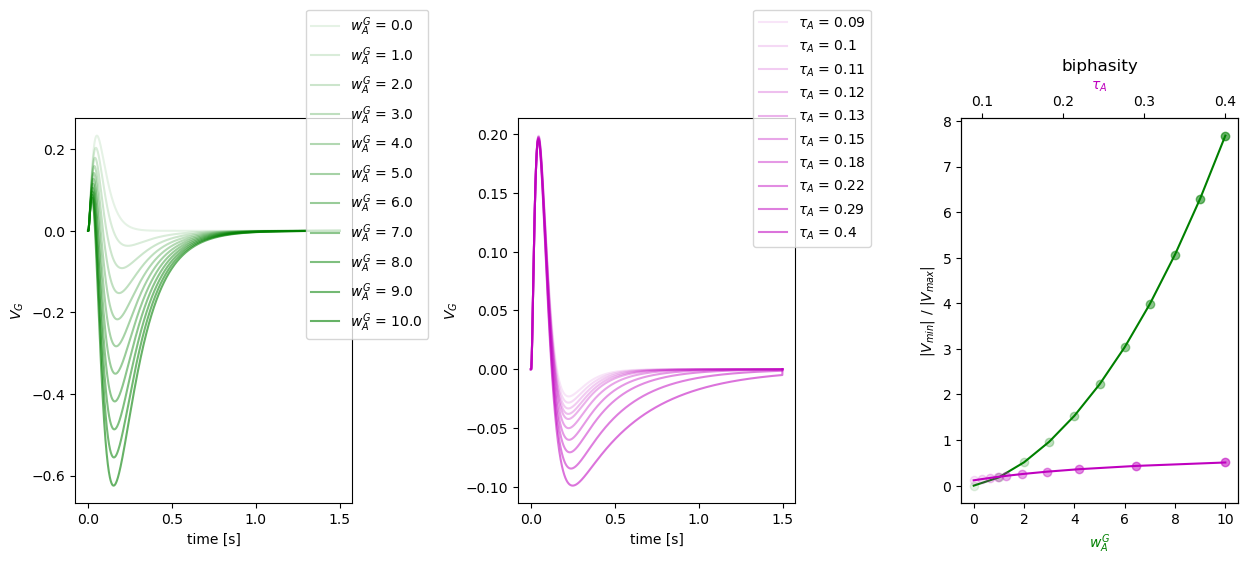

In [14]:
fig = plt.figure(figsize = (15,5))

gs = fig.add_gridspec(1,3)

ax0w = fig.add_subplot(gs[0,0])
ax0t = fig.add_subplot(gs[0,1])
ax1 = fig.add_subplot(gs[0,2])
ax1t = ax1.twiny()
# ax2 = fig.add_subplot(gs[1,1])
# ax2t = ax2.twiny()

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)


for i,val in enumerate(vals_w): 

    x = val

    ax0w.plot(time_impulse, signal_w[i], label = f'{wstring} = {val}', color = 'g', alpha = i*0.05+0.1)


    ax1.scatter(val,bif_w[i], zorder = 10, color = 'g', alpha = i*0.05+0.1)
    # ax2.scatter(val,freq_w[i], zorder = 10, color = 'g', alpha = i*0.05+0.1)


for i,val in enumerate(vals_tauA): 
    x = val
 

    ax0t.plot(time_impulse, signal_tau[i], label = f'{tstring} = {np.round(val,2)}', color = 'm', alpha = i*0.05+0.1)

 
    ax1t.scatter(val,bif_tau[i], zorder = 10, color = 'm', alpha = i*0.05+0.1)
    # ax2t.scatter(val,freq_tau[i], zorder = 10, color = 'm', alpha = i*0.05+0.1)


ax1t.plot(vals_tauA,bif_tau, color = 'm')
# ax2t.plot(vals_tau,freq_tau)

ax1.plot(vals_w,bif_w, color = 'g')
# ax2.plot(vals_w,freq_w)
  
  
ax0w.set_xlabel('time [s]')
ax0w.set_ylabel('$V_{G}$')
# ax0w.set_title('impulse response')

ax0t.set_xlabel('time [s]')
ax0t.set_ylabel('$V_{G}$')
# ax0t.set_title('impulse response')


ax1.set_xlabel(f'{wstring}', color = 'g')
ax1t.set_xlabel(f'{tstring}',color = 'm')
ax1.set_ylabel('$|V_{min}|$ / $|V_{max}|$')
ax1.set_title('biphasity')


# ax2.set_xlabel('wBA')
# ax2t.set_xlabel('tau')
# ax2.set_ylabel('$Hz$')
# ax2.set_title('frequency')

ax0t.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.3))
ax0w.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.3))

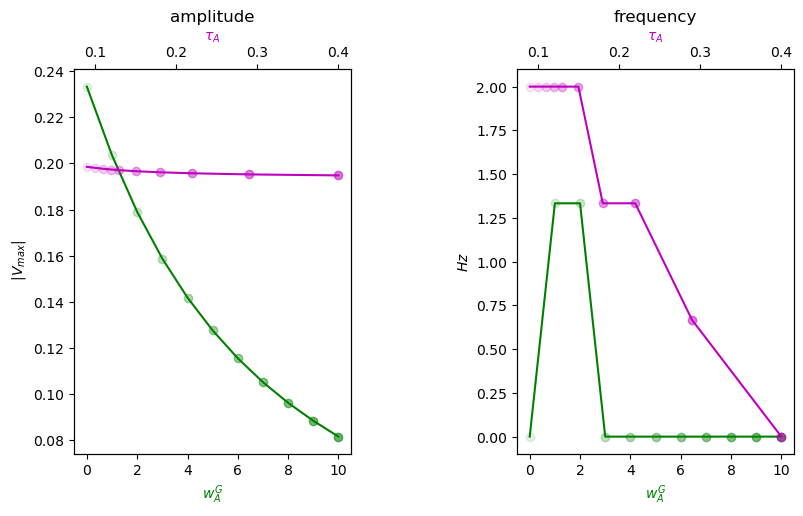

In [15]:
fig = plt.figure(figsize = (15,5))

gs = fig.add_gridspec(1,3)


ax1 = fig.add_subplot(gs[0,0])
ax1t = ax1.twiny()
ax2 = fig.add_subplot(gs[0,1])
ax2t = ax2.twiny()


fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)


for i,val in enumerate(vals_w): 

    x = val
    ax1.scatter(val,amp_w[i], zorder = 10, color = 'g', alpha = i*0.05+0.1)
    ax2.scatter(val,freq_w[i], zorder = 10, color = 'g', alpha = i*0.05+0.1)


for i,val in enumerate(vals_tauA): 
    
    x = val
    ax1t.scatter(val,amp_tau[i], zorder = 10, color = 'm', alpha = i*0.05+0.1)
    ax2t.scatter(val,freq_tau[i], zorder = 10, color = 'm', alpha = i*0.05+0.1)


ax1t.plot(vals_tauA,amp_tau, color = 'm')
ax2t.plot(vals_tauA,freq_tau, color = 'm')

ax1.plot(vals_w,amp_w, color = 'g')
ax2.plot(vals_w,freq_w, color ='g')
  


ax1.set_xlabel(f'{wstring}', color = 'g')
ax1t.set_xlabel(f'{tstring}',color = 'm')
ax1.set_ylabel(' $|V_{max}|$')
ax1.set_title('amplitude')


ax2.set_xlabel(f'{wstring}', color = 'g')
ax2t.set_xlabel(f'{tstring}', color = 'm')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

ax0t.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.3))
ax0w.legend(loc = 'upper right', bbox_to_anchor = (1.3,1.3))